In [1]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt 
from datetime import datetime
import lxml.etree as ET
import pandas as pd
import numpy as np
import os


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Create clusters by grouping articles that are about the same case



STEPS:
1. Create a distance matrix as 1 - [prob of being about the same case] for each pair of articles
2. Apply a clustering algorithm
3. Store clusters: cluster_id - tweet_id
4. Store a dataframe with information about the articles and their associated cluster_id

In [ ]:
INPUT_FILE_PATH = '../data/cases_pairwise_proba.csv'
NEWS_PATH = '../data/news/'
OUTPUT_PATH = '../data'

## Step 1 - Create distance matrix

In [2]:
pairs_df = pd.read_csv(INPUT_FILE_PATH)
pairs_df['tweet_id_A'] = pairs_df['tweet_id_A'].apply(lambda x: str(x))
pairs_df['tweet_id_B'] = pairs_df['tweet_id_B'].apply(lambda x: str(x))

In [3]:
all_tweet_ids = list(set(np.concatenate([pairs_df['tweet_id_A'].unique(), pairs_df['tweet_id_B'].unique()])))
mapping_keys = dict(zip(all_tweet_ids, range(len(all_tweet_ids))))
mapping_pos  = dict(zip(list(mapping_keys.values()), list(mapping_keys.keys())))

In [4]:
N = len(mapping_keys)
proba_matrix = np.zeros(shape=(N,N))
for i, row in pairs_df.iterrows():
    pos_A = mapping_keys[row['tweet_id_A']]
    pos_B = mapping_keys[row['tweet_id_B']]
    proba = row['same_case_pred_proba']
    
    proba_matrix[pos_A, pos_B] = 1- proba
    proba_matrix[pos_B, pos_A] = 1- proba

In [5]:
proba_matrix

array([[0.        , 0.99644699, 0.99805299, ..., 0.99983623, 0.99974146,
        0.99921544],
       [0.99644699, 0.        , 0.99936647, ..., 0.99961739, 0.9994083 ,
        0.99929988],
       [0.99805299, 0.99936647, 0.        , ..., 0.99899214, 0.99970602,
        0.99781439],
       ...,
       [0.99983623, 0.99961739, 0.99899214, ..., 0.        , 0.99921052,
        0.99946294],
       [0.99974146, 0.9994083 , 0.99970602, ..., 0.99921052, 0.        ,
        0.99947048],
       [0.99921544, 0.99929988, 0.99781439, ..., 0.99946294, 0.99947048,
        0.        ]])

## Step 2- Agglomerative clustering without number of clusters

In [6]:
# ward linkage cannot be used with precomputed affinity 
clustering = AgglomerativeClustering(n_clusters = None, affinity='precomputed',
                                     distance_threshold=0.3, linkage='average')
c_dict = {}
c_labels = clustering.fit_predict(proba_matrix)
for i, cluster_id in enumerate(c_labels):
    try:
        c_dict[cluster_id].append(mapping_pos[i])
    except:
        c_dict[cluster_id] = [mapping_pos[i]]

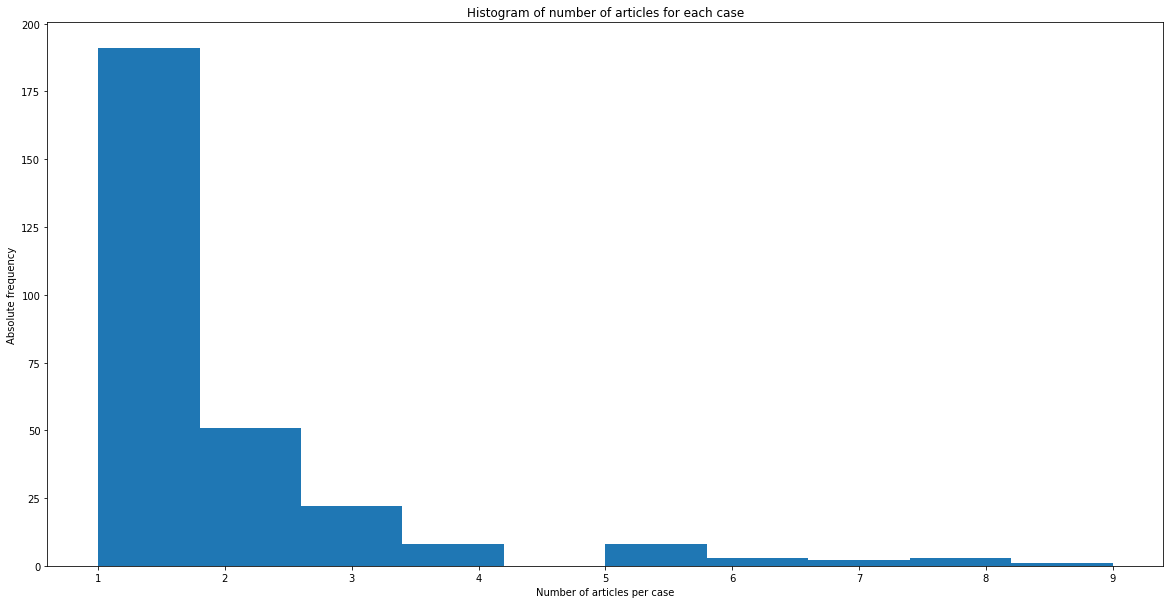

In [8]:
cases_length = [len(items) for key, items in c_dict.items()]

f = plt.figure(figsize = (20,10))
plt.title('Histogram of number of articles for each case')
plt.hist(cases_length)
plt.xlabel('Number of articles per case')
plt.ylabel('Absolute frequency')
plt.show()

In [9]:
clustering.get_params()

{'affinity': 'precomputed',
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': 0.3,
 'linkage': 'average',
 'memory': None,
 'n_clusters': None}

### Steps 3 and 4 - Store the data in two different formats
- cases_ids.csv --> for working later with the clusters
- cases_info.csv --> for visualization purposes

In [7]:
cases_df = pd.DataFrame(columns=['case_id', 'tweet_ids'])
for case_id, list_t in c_dict.items():
    cases_df = cases_df.append({'case_id': case_id, 'tweet_ids': list_t}, ignore_index = True)


cases_df.to_csv(f'data/cases_ids.csv', index = False)

In [10]:
def listdir_checked(path, unwanted = ['.DS_Store']):
    '''
    Discard unwanted files or directories when listing the elements in a given path
    '''
    return (f for f in os.listdir(path) if f not in unwanted)


def create_articles_dictionary(NEWS_PATH):
    '''
    Import articles information.
    Articles are stored in directories in the NEWS_PATH.
    '''
    data = {}               # keys: media, value: list of dictionaries with info about the news articles of the given media
    unique_urls = []        # list to store unique urls to discard repeated ones
    repeated_data = {}      # store repeated articles following the same format as 'data' dictionary

    for directory in listdir_checked(NEWS_PATH):
        for file in listdir_checked(NEWS_PATH + directory):
            full_path = NEWS_PATH + directory + '/' + file
            # Read xml file - info stored following NewsML-G2 format
            root = ET.parse(full_path).getroot()
            # Parse news
            media = file.rsplit('_', 1)[0]
            # Check repeated urls
            url = root.findall(".//infoSource")[0].get("uri")
            str_date = root.findall('.//contentMeta')[0].find('contentCreated').text[:10]
            info = {
                'id': file.split(':')[-1].replace('.xml', ''),
                'media': media,
                'publication_date': datetime.strptime(str_date, '%Y-%m-%d'),
                'title': root.findall('.//itemRef')[0].find('title').text,
                'headline': root.findall(".//itemRef")[0].find('description').text.strip(),
                'article': root.findall('.//itemRef')[1].find('description').text.strip(),
                'url': url
            }

            if url not in unique_urls:
                unique_urls.append(url)
                try:
                    data[media].append(info)
                except:
                    data[media] = [info]

            else:
                try:
                    repeated_data[media].append(info)
                except:
                    repeated_data[media] = [info]
                    
    return data, repeated_data


def get_data_info(data, dict_key, value):
    '''
    Aux function to obtain the info of the articles with the given 
    value for the provided dict_key in data
    '''
    matching_elements = []
    for media, news in data.items():
        for article in news:
            if article[dict_key] == value:
                matching_elements.append(article)
    return matching_elements


In [11]:
# IMPORT INFORMATION ABOUT ARTICLES
data, repeated_data = create_articles_dictionary(NEWS_PATH)

In [12]:
clusters_df = pd.DataFrame(columns = ['cluster_id', 'tweet_id', 'article_title', 'media'])
for i, row in cases_df.iterrows():
    for t_id in row['tweet_ids']:
        clusters_df = clusters_df.append({'cluster_id': row['case_id'], 
                                          'tweet_id': t_id, 
                                          'article_title': get_data_info(data,'id', t_id)[0]['title'],
                                          'media': get_data_info(data, 'id', t_id)[0]['media']},
                                        ignore_index = True)  
if store:
    clusters_df.to_csv(f'{OUTPUT_PATH}/cases_info.csv', index=False)